# Implementación de una *Convolutional Neural Net, CNN*

**Diego Alberto Barriga Martínez**

## Dataset

Se utilizará el dataset MNIST

In [ ]:
!pip install -U torch torchvision

In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torchvision
from torchvision import transforms, datasets
from torch.utils.data import Subset, DataLoader

In [ ]:
IMAGE_PATH = "./"
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
EPOCHS = 20

In [ ]:
transform  = transforms.Compose([transforms.ToTensor()])
mnist_dataset = datasets.MNIST(root=IMAGE_PATH, train=True, transform=transform, download=True)

100%|██████████| 9.91M/9.91M [00:02<00:00, 4.95MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 131kB/s]
100%|██████████| 1.65M/1.65M [00:01<00:00, 1.25MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 8.83MB/s]


### Train, test, val

In [ ]:
mnist_validation = Subset(mnist_dataset, torch.arange(10000))
mnist_train = Subset(mnist_dataset, torch.arange(10000, len(mnist_dataset)))
# Ya debe estar descargado por la celda anterior
mnist_test = datasets.MNIST(root=IMAGE_PATH, train=False, transform=transform, download=False)

### Cargador de datos

In [ ]:
batch_size = 64
train_dataloader = DataLoader(mnist_train, batch_size=batch_size)
validation_dataloader = DataLoader(mnist_validation, batch_size=batch_size)

## Implementación de la red

In [ ]:
class MyCNN(nn.Module):
    def __init__(self):
        super(MyCNN, self).__init__()
        # Primera parte: Convolucional y Pooling
        # Feature extractor: 6 capas
        self.feature = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=32, kernel_size=5, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=5, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )

        # Capa para aplanar matriz
        self.flatten = nn.Flatten()

        # Segunda parte: Clasificador
        # 4 capas
        self.classifier = nn.Sequential(
            nn.Linear(in_features=64*7*7, out_features=1024),
            nn.ReLU(),
            # Usamos Dropout
            nn.Dropout(),
            nn.Linear(in_features=1024, out_features=10)
        )

    def forward(self, x):
        # Extrayendo features
        features = self.feature(x)
        # Aplicando aplanado para la capa lineal del clasificador
        features_flat = self.flatten(features)
        # Aplicando clasificador
        out = self.classifier(features_flat)
        return out

In [ ]:
print(f"Usando el dispositivo: {DEVICE}")
model = MyCNN().to(DEVICE)

Usando el dispositivo: cuda


### Optimizadores y función de perdida

In [ ]:
# Función de pérdida: Entropía Cruzada
loss_fn = nn.CrossEntropyLoss()
# Optimizador (Gradiente): Adam
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

## Función de entrenamiento

In [ ]:
def calculate_validation_loss(model, validation_data, loss_hist, acc_hist, epoch):
    model.eval()
    with torch.no_grad():
        for x_batch, y_batch in validation_data:
            x_batch = x_batch.to(DEVICE)
            y_batch = y_batch.to(DEVICE)
            y_pred = model(x_batch)
            loss = loss_fn(y_pred, y_batch)
            loss_hist[epoch] += loss.item() * y_batch.size(0)
            is_correct = (torch.argmax(y_pred, dim=1) == y_batch).float()
            acc_hist[epoch] += is_correct.sum()
        loss_hist[epoch] /= len(validation_data.dataset)
        acc_hist[epoch] /= len(validation_data.dataset)
    return loss_hist, acc_hist

def train(model, train_data, valid_data, epochs):
    loss_hist_train = [0] * epochs
    accuracy_hist_train = [0] * epochs

    loss_hist_valid = [0] * epochs
    accuracy_hist_valid = [0] * epochs

    for epoch in range(epochs):
        # Entrenamiento
        model.train()
        for x_batch, y_batch in train_data:
            x_batch = x_batch.to(DEVICE)
            y_batch = y_batch.to(DEVICE)
            # Realiza la predicción
            y_pred = model(x_batch)
            # Calcular pérdida
            loss = loss_fn(y_pred, y_batch)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

            # Guardando historial de loss
            loss_hist_train[epoch] += loss.item() * y_batch.size(0)
            is_correct = (torch.argmax(y_pred, dim=1) == y_batch).float()
            accuracy_hist_train[epoch] += is_correct.sum()

        loss_hist_train[epoch] /= len(train_data.dataset)
        accuracy_hist_train[epoch] /= len(train_data.dataset)

        # Validación
        loss_hist_valid, accuracy_hist_valid = calculate_validation_loss(
            model,
            valid_data,
            loss_hist_valid,
            accuracy_hist_valid,
            epoch
        )
        print(f"Epoch: {epoch} - Accuracy Train: {accuracy_hist_train[epoch]:.4f} - Accuracy Validation: {accuracy_hist_valid[epoch]:.4f}")

    return loss_hist_train, accuracy_hist_train, loss_hist_valid, accuracy_hist_valid

In [ ]:
%%time
history = train(model, train_dataloader, validation_dataloader, EPOCHS)

Epoch: 0 - Accuracy Train: 0.9492 - Accuracy Validation: 0.9765
Epoch: 1 - Accuracy Train: 0.9840 - Accuracy Validation: 0.9878
Epoch: 2 - Accuracy Train: 0.9900 - Accuracy Validation: 0.9880
Epoch: 3 - Accuracy Train: 0.9924 - Accuracy Validation: 0.9890
Epoch: 4 - Accuracy Train: 0.9934 - Accuracy Validation: 0.9898
Epoch: 5 - Accuracy Train: 0.9947 - Accuracy Validation: 0.9888
Epoch: 6 - Accuracy Train: 0.9959 - Accuracy Validation: 0.9885
Epoch: 7 - Accuracy Train: 0.9962 - Accuracy Validation: 0.9907
Epoch: 8 - Accuracy Train: 0.9962 - Accuracy Validation: 0.9905
Epoch: 9 - Accuracy Train: 0.9972 - Accuracy Validation: 0.9907
Epoch: 10 - Accuracy Train: 0.9970 - Accuracy Validation: 0.9887
Epoch: 11 - Accuracy Train: 0.9979 - Accuracy Validation: 0.9882
Epoch: 12 - Accuracy Train: 0.9970 - Accuracy Validation: 0.9898
Epoch: 13 - Accuracy Train: 0.9974 - Accuracy Validation: 0.9917
Epoch: 14 - Accuracy Train: 0.9980 - Accuracy Validation: 0.9916
Epoch: 15 - Accuracy Train: 0.9979 

### Mostrando el *accuracy* y la perdida a lo largo del entrenamiento

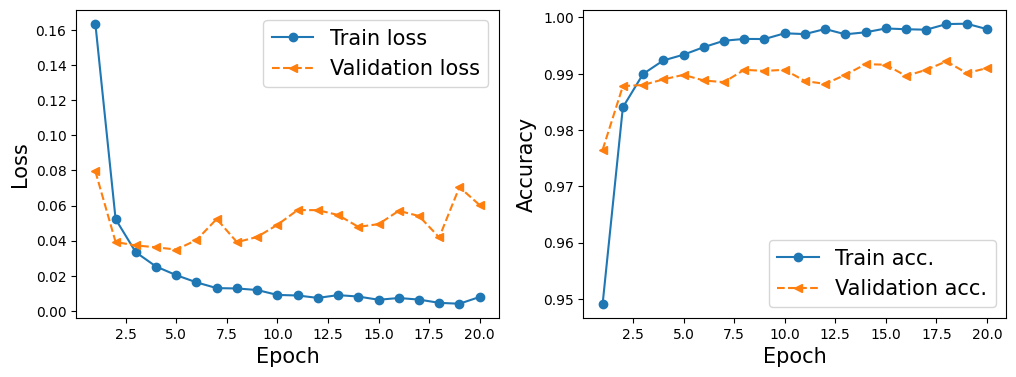

In [ ]:
x_arr = np.arange(len(history[0])) + 1

fig = plt.figure(figsize=(12, 4))
ax = fig.add_subplot(1, 2, 1)
ax.plot(x_arr, history[0], '-o', label='Train loss')
ax.plot(x_arr, history[2], '--<', label='Validation loss')
ax.set_xlabel('Epoch', size=15)
ax.set_ylabel('Loss', size=15)
ax.legend(fontsize=15)

ax = fig.add_subplot(1, 2, 2)
ax.plot(x_arr, [h.cpu() for h in history[1]], '-o', label='Train acc.')
ax.plot(x_arr, [h.cpu() for h in history[3]], '--<', label='Validation acc.')
ax.legend(fontsize=15)
ax.set_xlabel('Epoch', size=15)
ax.set_ylabel('Accuracy', size=15)

plt.show()

## Probando el modelo

In [ ]:
predictions = model(mnist_test.data.unsqueeze(1).float().to(DEVICE) / 255.)
is_correct = (torch.argmax(predictions, dim=1) == mnist_test.targets.to(DEVICE)).float()
print(f"Test Accuracy: {is_correct.mean():.4f}")

Test Accuracy: 0.9924


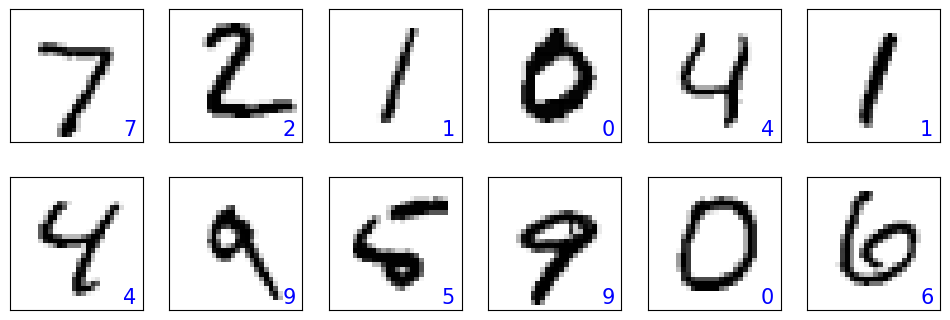

In [ ]:
fig = plt.figure(figsize=(12, 4))
for i in range(12):
    ax = fig.add_subplot(2, 6, i+1)
    ax.set_xticks([]); ax.set_yticks([])
    img = mnist_test[i][0][0, :, :]
    # Move the image tensor to the same device as the model
    pred = model(img.unsqueeze(0).unsqueeze(1).to(DEVICE))
    y_pred = torch.argmax(pred)
    ax.imshow(img, cmap='gray_r')
    ax.text(0.9, 0.1, y_pred.item(),
            size=15, color='blue',
            horizontalalignment='center',
            verticalalignment='center',
            transform=ax.transAxes)
plt.show()

In [ ]:

print("Hola mundo")